In [14]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os, re, math, scipy.io, time
import seaborn as sns
from scipy.spatial.distance import directed_hausdorff
from sklearn.cluster import DBSCAN
import traj_dist.distance as tdist
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
#%matplotlib inline

In [37]:
# Some visualization stuff, not so important
sns.set()
plt.rcParams['figure.figsize'] = (12, 12)

# Utility Functions
color_lst = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_lst.extend(['firebrick', 'olive', 'indigo', 'khaki', 'teal', 'saddlebrown',
                 'skyblue', 'coral', 'darkorange', 'lime', 'darkorchid', 'dimgray'])
INDEX_RANGE = 1305

In [65]:
def convert_data_into_np_array(number_of_pcs = 2):
    STAGE_DATA_DIR = 'DATA/stage_data'
    data_dict = {}
    traj_list = []
    pair_indexs = range(1, INDEX_RANGE + 4)
    for dir_name in os.listdir(STAGE_DATA_DIR):
        if os.path.isdir(os.path.join(STAGE_DATA_DIR, dir_name)):
            dir_index = int(dir_name.split("_")[0])
            data_fp = os.path.join(STAGE_DATA_DIR, dir_name, "stage_metrics.csv")
            df = pd.read_csv(data_fp, sep=",", header=0).values
            data_dict[dir_index] = {}
            data_dict[dir_index]['pair_name'] = '_'.join(re.sub(r'[\[|\]|\\|\'|\s]', '', df[0, 4]).split(','))
            pcs = df[:, 7: 7 + number_of_pcs].astype(float)
            data_dict[dir_index]['pcs'] = pcs
    pairs_name = ["sox2_t", "gata5_pax8", "lhx1_pax8"]
    for pid, pair in enumerate(pairs_name):
        input_fp = "DATA/%s.csv" % pair
        pcs = pd.read_csv(input_fp, sep=",", header=0).values
        d_id = INDEX_RANGE + pid + 1
        data_dict[d_id] ={}
        data_dict[d_id]['pair_name'] = pair
        data_dict[d_id]['pcs'] = pcs
    for key in pair_indexs:
        traj = data_dict[key]['pcs']
        traj_list.append(traj)
        plt.plot(traj[:, 0], traj[:, 1])
    plt.show()
    return [data_dict, traj_list]

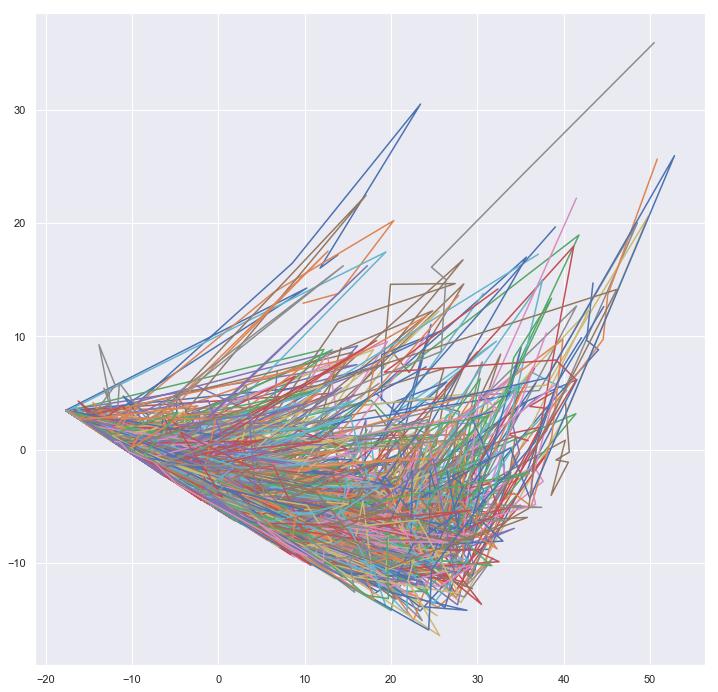

In [66]:
[data_dict, traj_list] = convert_data_into_np_array()

In [67]:
def calc_distance_matrix(distance_fp, traj_list):
    ts = time.time()
    p_dist = tdist.pdist(traj_list, metric="sspd")
    nb_dist = len(p_dist)
    te = time.time()
    print("%d Distances computed in %d seconds" % (nb_dist, te - ts))
    np.save(distance_fp, p_dist)

In [68]:
distance_fp = 'DATA/pair_distance_matrix.npy'
calc_distance_matrix(distance_fp, traj_list)

Computing euclidean distance sspd with implementation cython for 1308 trajectories
854778 Distances computed in 36 seconds


In [69]:
import fastcluster as fc
import scipy.cluster.hierarchy as sch
import pickle

In [96]:
N_CLUSTER = 30
EACH_SUB_FIG_SIZE = 5
p_dist = np.load(distance_fp)
Z = fc.linkage(p_dist, method="ward")
labels =sch.fcluster(Z, N_CLUSTER , criterion="maxclust")-1
label_fp = "DATA/pair_distance_labels.pkl"
pickle.dump(labels, open(label_fp, "wb"))

In [97]:
def plot_cluster(traj_lst, cluster_lst):
    '''
    Plots given trajectories with a color that is specific for every trajectory's own cluster index.
    Outlier trajectories which are specified with -1 in `cluster_lst` are plotted dashed with black color
    '''
    
    N_COL = 5
    N_ROW = int(math.ceil(N_CLUSTER / N_COL))
    fig, axs = plt.subplots(N_ROW, N_COL, figsize=(N_COL * EACH_SUB_FIG_SIZE, N_ROW * EACH_SUB_FIG_SIZE))
    for index, (traj, cluster) in enumerate(zip(traj_lst, cluster_lst)):
        row = cluster // N_COL
        col = cluster % N_COL
        if N_ROW > 1:
            ax = axs[row][col]
        else:
            ax = axs[cluster]
        data_index = index + 1
        if  data_index > INDEX_RANGE:
            # Means it it a noisy trajectory, paint it black
            ax.plot(traj[:, 0], traj[:, 1], c='k', linestyle='dashed')
            ax.text(0, 0, data_dict[data_index]['pair_name'], color='black')
        else:
            ax.plot(traj[:, 0], traj[:, 1], c=color_lst[cluster % len(color_lst)])
        ax.set_xlim(-20, 60)
        ax.set_ylim(-20, 50)
    plt.savefig("CLUSTER.png", dpi=200)
    plt.show()

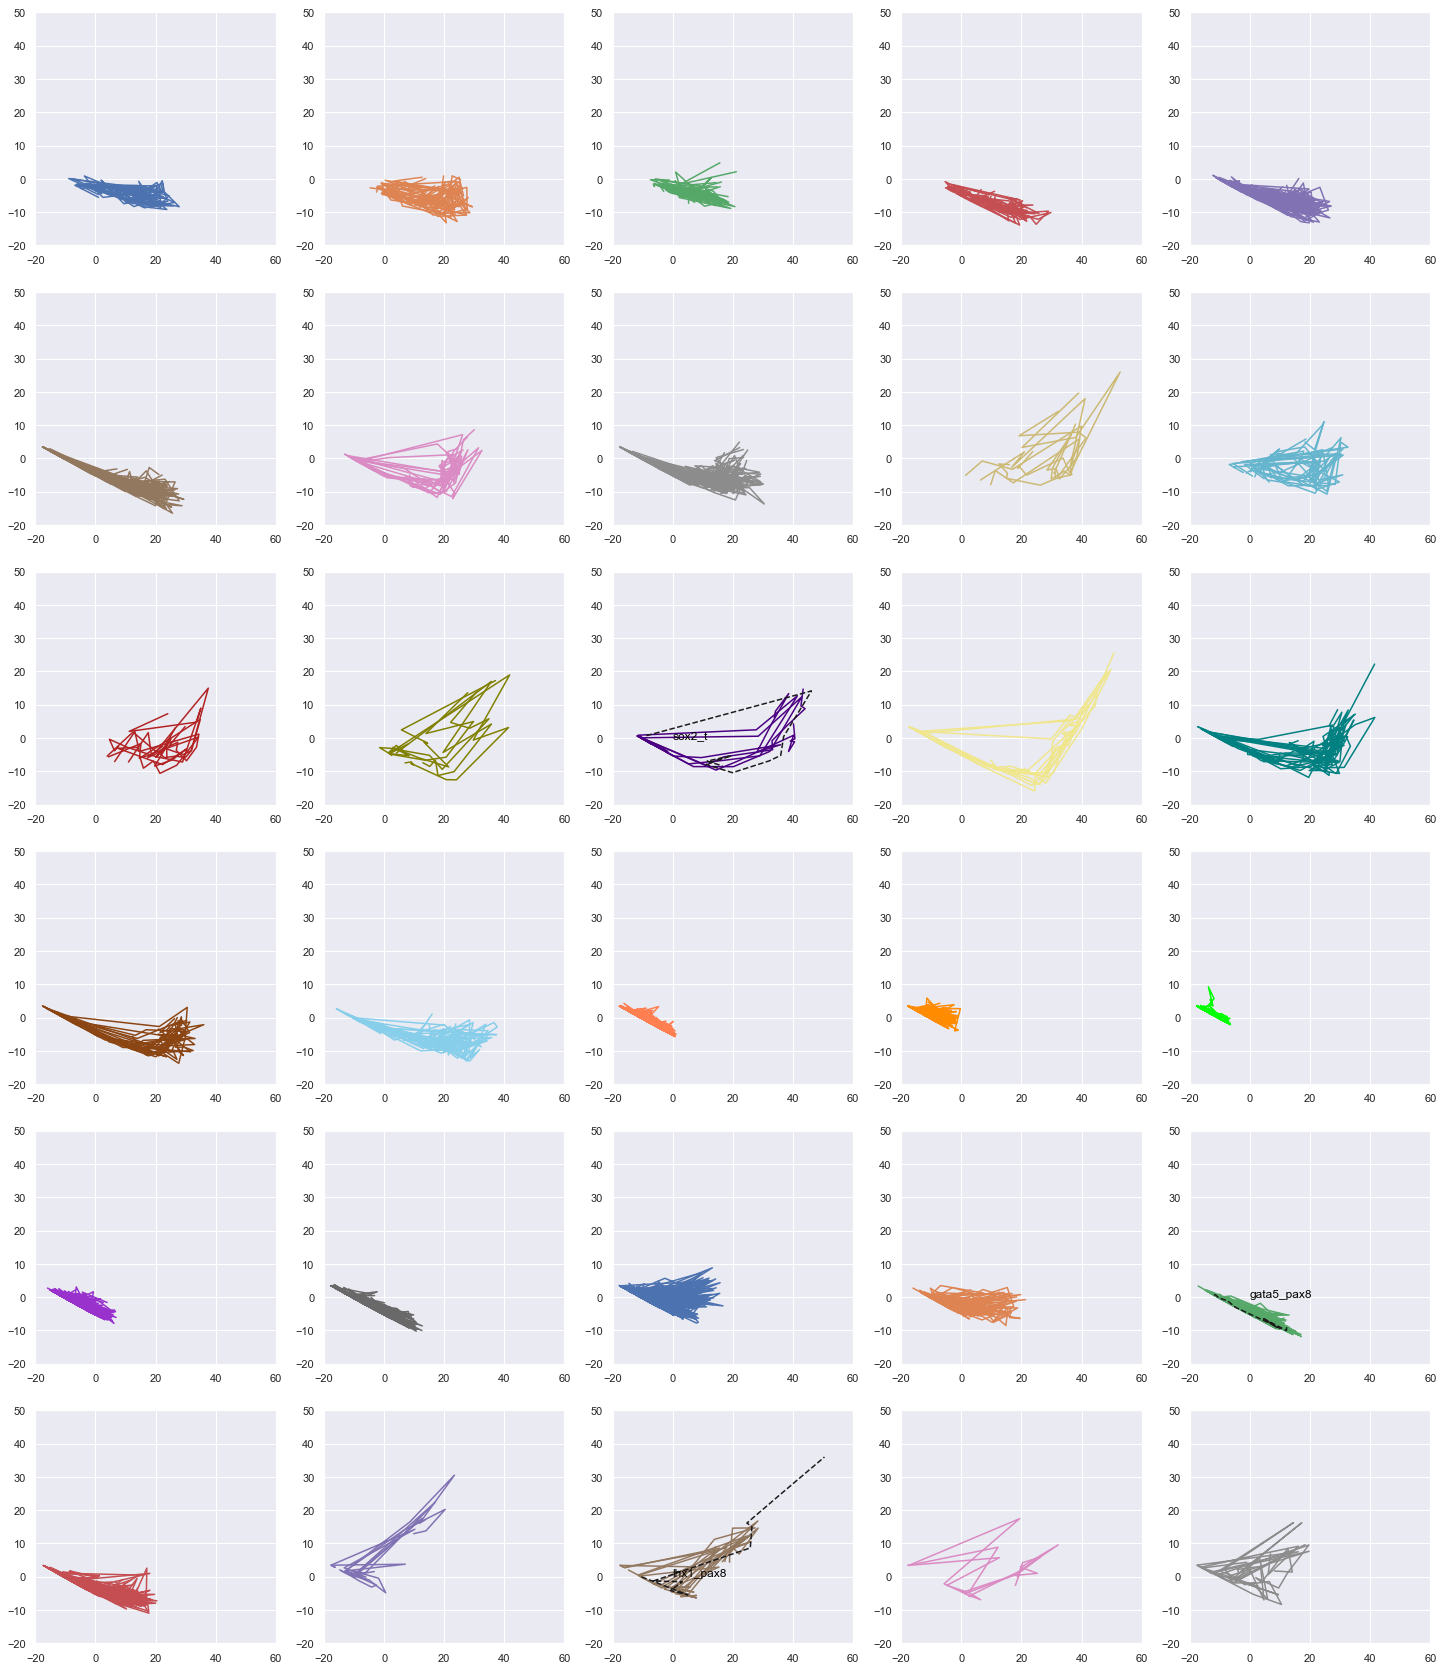

In [98]:
plot_cluster(traj_list, labels)